## Analiza zarobków analityków danych i zawodów pokrewnych na świecie z podziałem na stanowiska. 

[Górski Szymon](https://github.com/SzymonTomasz), [Szura Michał](https://github.com/Malamity) i [Stano Paweł](https://github.com/pstano1)

#### Spis treści:
- [Wstęp](#wstep)
- [Metodologia](#metodologia)
- [Podział stanowisk](#podzial-stanowisk)
- [Analiza zarobków dla wybranych państw](#)
- [Analiza zarobków według stanowiska](#analiza-zarobkow-wedlug-stanowiska)
- [Wnioski](#wnioski)
- [Blibliografia](#bibliografia)
- [Aneksy](#aneksy)

TODO:
- read csv do dataframe
- clean data (sprawdzic w wykladzie) na przyklad dropnan/inan (opcjonalnie usunięcie wartości skrajnych)
- analiza: group by (np country/stanowisko/firma) + miary tendencji centralnej (moda, mediana, średnia)
- Wykres do powyzszego.

jak zdążymy:
- analiza wewnątrze dla wybranego przez usera kraj (np breakdown by stanowisko/firma)
- analiza per firma niezależnie od kraju
- analiza per stanowisko
- zaczynamy od pisania tego w funkcjach, jak zdążymy wrzucamy fnkcje na metody wewnętrzne obietu

:bulb: porównanie w parytecie, natomaist to wymagałoby znaleźenia danych indeksów CPI

### Wstęp

Analityka danych i pokrewne zawody stały się nieodzowną częścią strategii rozwoju nowoczesnych firm w ostatniej dekadzie. Dzięki zdolności do zbierania, przetwarzania i interpretowania danych, specjaliści w tej dziedzinie pomagają firmom podejmować lepsze decyzje biznesowe i zyskiwać przewagę konkurencyjną. Wzrost znaczenia analizy danych wiąże się również ze wzrostem zarobków specjalistów, co czyni tę profesję atrakcyjną na całym świecie.

Celem tego raportu jest analiza zarobków analityków danych i pokrewnych zawodów na świecie, uwzględniająca różnice między poszczególnymi stanowiskami oraz regionami geograficznymi. 

### Metodologia

#### Źródła danych

W niniejszym raporcie wykorzystano dane pochodzące z kilku głównych źródeł:

1. Zbiór danych o zarobkach: Dane dotyczące wynagrodzeń analityków danych i pokrewnych zawodów zostały pozyskane z platformy `kaggle` i zostały przygotowane na podstiwe danych udostępnionych przez platformę `Glassdoor`, która gromadzi informacje na temat wynagrodzeń pracowników na podstawie raportów zgłaszanych przez użytkowników i analizy rynkowej.

2. Tabele Narodowego Banku Polskiego (NBP): Dane dotyczące kursów walut pochodzą z Tabel Narodowego Banku Polskiego, zapewniając jednolitą bazę do porównań zarobków w różnych regionach geograficznych.

#### Meteody analizy

##### Narzędzia

In [218]:
import requests as re
import json
import base64
import zipfile
import pandas as pd
import csv
import unicodedata
import numpy as np
from io import BytesIO, StringIO
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [219]:
salary_file = r'./salaries.csv'
dataset = []
with open(salary_file, newline='', encoding ='utf-8') as csvfile:
    spamreader = csv.reader(csvfile,delimiter='\t', quotechar=u'\xa0')
    for row in spamreader:
        row = [unicodedata.normalize('NFC',i)  for i in row]
        dataset.append(row)

salaries_df = pd.DataFrame(columns = dataset[0][:-1], data = dataset[1:])
salaries_df.head(5)

,role,country,company,company_rating,job_title,median,low,high,unit
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"¥1,500,000",¥1M,¥18M,/yr
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"¥5,000,000",¥5M,¥7M,/yr
2,Data Scientist,Japan,GMO Internet,3.3,Data Scientist,"¥6,500,000",¥7M,-,/yr
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"¥350,000",¥300K,¥402K,/mo
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"¥6,250,000",¥5M,¥8M,/yr


In [220]:
from typing import Callable

class GlassdoorSalary:
  base_url = "https://www.kaggle.com/api/v1"
  owner = "imbishal7"
  dataset_name = "glassdoor-salary"
  filename = "salaries.csv"
  version = 1

  def __init__(self, username: str, key: str, currency_codes: dict) -> None:
    self.username = username
    self.key = key
    self.currency_symbols = currency_codes

    credentials = base64.b64encode(bytes(f"{self.username}:{self.key}", "ISO-8859-1")).decode("ascii")
    self.headers = {
      "Authorization": f"Basic {credentials}"
    }
    self.dataset = pd.DataFrame()

  def load_dataset(self) -> None:
    '''
      Loads dataset from specified link, unzips it & clears the empty cells
    '''
    url = f'{self.base_url}/datasets/download/{self.owner}/{self.dataset_name}?datasetVersionNumber={self.version}'
    res: re.Response 
    try:
      res = re.get(url, headers=self.headers, stream=True)
    except Exception as e:
      print(e)
      return 
    
    try:
      zf = zipfile.ZipFile(BytesIO(res.content))
      with zf.open(self.filename) as f:
        content = f.read().decode('utf-8')
        f = StringIO(content)
        set = []
        spamreader = csv.reader(f, delimiter='\t', quotechar=u'\xa0')
        for row in spamreader:
            row = [unicodedata.normalize('NFC',i)  for i in row]
            set.append(row)

        self.dataset = pd.DataFrame(columns = set[0][:-1], data = set[1:])
        self.dataset = self.dataset[~self.dataset.isin(['NA', '-']).any(axis=1)]
        self.dataset = self.dataset.dropna()
    except Exception as e:
        print(e)
        return
  
  def process_data(self) -> None:
    '''
      Proccesses the data columns containing money values (median, high, low)
      example: a monetary field of high bound of pay range 
      may be written as $1M, this function clears this mess up
      by writting $ to `currency` as `USD` column & changing 1M into 
      proper numeric value of 1000000
    '''
    def convert_to_proper_number(value):
      multiplier = 1
      if 'K' in value:
          multiplier = 1000
      elif 'M' in value:
          multiplier = 1000000
      value = value.replace('K', '')
      value = value.replace('M', '')
      
      return float(value) * multiplier
  
    currency_codes = self.dataset['median'].str.extract(r'^(\w+)', expand=False)
      
    self.dataset['currency'] = currency_codes.map(self.currency_symbols)
    self.dataset['currency'] = self.dataset['currency'].fillna(currency_codes)
  
    symbols = self.dataset.loc[self.dataset['currency'].isna(), 'median'].str.extract(r'([^\d\.\-KM])', expand=False).fillna('')
    self.dataset['currency'] = self.dataset['currency'].fillna(symbols.map(self.currency_symbols))
        
    self.dataset['currency'] = self.dataset['currency'].fillna(symbols)
    
    self.dataset['median'] = self.dataset['median'].str.replace(r'[^\d\.\-]', '', regex=True).astype(float)
    self.dataset['low'] = self.dataset['low'].str.replace(r'[^\d\.\-KM]', '', regex=True).apply(convert_to_proper_number)
    self.dataset['high'] = self.dataset['high'].str.replace(r'[^\d\.\-KM]', '', regex=True).apply(convert_to_proper_number)

    self.dataset = self.remove_outliers('median', 'country')

  def get_dataset(self) -> pd.DataFrame:
    return self.dataset
  
  def select_by_hourly_rate(self) -> pd.DataFrame:
    def convert_to_hr_rate(value, unit):
      conversion_factors = {
        '/yr': 12 * 160,
        '/mo': 160,
        '/hr': 1
      }

      return value / conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_hr_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/hr'

    return self.get_dataset()
  
  def select_by_monthly_rate(self) -> pd.DataFrame:
    def convert_to_mo_rate(value, unit):
      conversion_factors = {
        '/yr': (1/12),
        '/mo': 1,
        '/hr': 160
      }

      return value * conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_mo_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/mo'

    return self.get_dataset()
  
  def select_by_yearly_rate(self) -> pd.DataFrame:
    def convert_to_mo_rate(value, unit):
      conversion_factors = {
        '/yr': 1,
        '/mo': 12,
        '/hr': 160*12
      }

      return value * conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_mo_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/yr'

    return self.get_dataset()
  
  def to_common_currency(self, to_currency: str, get_exchange_rate: Callable[[str, str], float]) -> pd.DataFrame:
    '''
      Converts salary data to a specified common currency for unified analysis
    '''
    def convert_value(row, column):
      from_currency = row['currency']
      value = row[column]
      if from_currency == to_currency:
        return value
      exchange_rate = get_exchange_rate(from_currency, to_currency)
      
      return value * exchange_rate
    
    self.dataset[to_currency + '_median'] = self.dataset.apply(lambda row: convert_value(row, 'median'), axis=1)
    self.dataset[to_currency + '_low'] = self.dataset.apply(lambda row: convert_value(row, 'low'), axis=1)
    self.dataset[to_currency + '_high'] = self.dataset.apply(lambda row: convert_value(row, 'high'), axis=1)
    
    return self.get_dataset()
  
  def remove_outliers(self, column: str, group_by: str) -> pd.DataFrame:
    def filter_group(group):
      Q1 = group[column].quantile(0.25)
      Q3 = group[column].quantile(0.75)

      IQR = Q3 - Q1

      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
    
    return self.dataset.groupby(group_by).apply(filter_group).reset_index(drop=True)

  def calculate_mean(self, column: str) -> float:
    return self.dataset[column].mean()
  
  def calculate_grouped_mean(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].mean().reset_index()
  
  def get_unique_values(self, column_name: str):
    return self.dataset[column_name].unique()
  
  def calculate_mode(self, column: str):
    return self.dataset[column].mode()
  
  def calculate_grouped_mode(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].apply(lambda x: x.mode()).reset_index()
  
  def calculate_median(self, column: str) -> float:
    return self.dataset[column].median()
  
  def calculate_grouped_median(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].median().reset_index()
  
  def calculate_std(self, column: str) -> pd.DataFrame:
    return self.dataset[column].std()
  
  def calculate_grouped_std(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].std().reset_index()

In [221]:
class ExchangeProvider:
    currencies = {}

    def __init__(self, tables_wanted, currency_symbols):
        self.symbol_map = currency_symbols
        for table_name in tables_wanted:
            json_nbp_curr = re.get(f"http://api.nbp.pl/api/exchangerates/tables/{table_name}/last/1/?format=json").json()
            for rate in json_nbp_curr[0]['rates']:
                self.currencies[rate['code']] = rate['mid']

    def get_rate(self, from_currency, to_currency):
        if from_currency == to_currency:
            return 1

        from_rate = 0
        to_rate = 0

        if to_currency == "PLN":
            return  self.currencies[from_currency]
        elif from_currency == "PLN":
            return 1 / self.currencies[to_currency]
        else:
            try:
                from_rate = self.currencies[from_currency]
            except Exception as e:
                print(f"{e}")
                return -1
            
            try:
                to_rate = self.currencies[to_currency]
            except Exception as e:
                print(f"{e}")
                return -1
            
            return from_rate / to_rate
        
    def exchange_symbol_for_code(self, symbol: str) -> str:
        return self.symbol_map[symbol]


In [222]:
with open('./currencies.json', encoding='utf8') as f:
    currencies = json.load(f)

exchange_provider = ExchangeProvider(["a", "b"], currencies)

In [223]:
with open('./kaggle.json', encoding='utf8') as f: 
    credentials = json.load(f)

a = GlassdoorSalary(credentials['username'], credentials['key'], currencies)
a.load_dataset()
a.process_data()
a.get_dataset()

,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"135,275.00","130,000.00","141,000.00",/mo,ARS
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"200,004.00","193,000.00","207,000.00",/mo,ARS
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"88,726.00","85,000.00","93,000.00",/mo,ARS
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"150,000.00","100,000.00","228,000.00",/mo,ARS
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"149,630.00","144,000.00","155,000.00",/mo,ARS
...,...,...,...,...,...,...,...,...,...,...
361563,Business Intelligence Developer,Vietnam,ShopeePay,3.5,Business Intelligence Analyst,"20,917,680.00","20,000,000.00","22,000,000.00",/mo,VND
361564,Business Intelligence Developer,Vietnam,GAPO Social Network Service,4.4,Business Intelligence Analyst,996.00,956.00,"1,000.00",/mo,VND
361565,Business Intelligence Developer,Vietnam,Curnon Watch,5,Business Intelligence Analyst,"8,016,400.00","8,000,000.00","8,000,000.00",/mo,VND
361566,Business Intelligence Developer,Vietnam,BeetSoft (Vietnam),4.3,Business Intelligence Analyst,"3,086,453.00","3,000,000.00","3,000,000.00",/mo,VND


In [224]:
a.select_by_yearly_rate()

,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"1,623,300.00","1,560,000.00","1,692,000.00",/yr,ARS
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"2,400,048.00","2,316,000.00","2,484,000.00",/yr,ARS
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"1,064,712.00","1,020,000.00","1,116,000.00",/yr,ARS
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"1,800,000.00","1,200,000.00","2,736,000.00",/yr,ARS
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"1,795,560.00","1,728,000.00","1,860,000.00",/yr,ARS
...,...,...,...,...,...,...,...,...,...,...
361563,Business Intelligence Developer,Vietnam,ShopeePay,3.5,Business Intelligence Analyst,"251,012,160.00","240,000,000.00","264,000,000.00",/yr,VND
361564,Business Intelligence Developer,Vietnam,GAPO Social Network Service,4.4,Business Intelligence Analyst,"11,952.00","11,472.00","12,000.00",/yr,VND
361565,Business Intelligence Developer,Vietnam,Curnon Watch,5,Business Intelligence Analyst,"96,196,800.00","96,000,000.00","96,000,000.00",/yr,VND
361566,Business Intelligence Developer,Vietnam,BeetSoft (Vietnam),4.3,Business Intelligence Analyst,"37,037,436.00","36,000,000.00","36,000,000.00",/yr,VND


In [225]:
a.to_common_currency('EUR', exchange_provider.get_rate)

,role,country,company,company_rating,job_title,median,low,high,unit,currency,EUR_median,EUR_low,EUR_high
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"1,623,300.00","1,560,000.00","1,692,000.00",/yr,ARS,"1,675.98","1,610.63","1,746.91"
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"2,400,048.00","2,316,000.00","2,484,000.00",/yr,ARS,"2,477.94","2,391.17","2,564.62"
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"1,064,712.00","1,020,000.00","1,116,000.00",/yr,ARS,"1,099.27","1,053.10","1,152.22"
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"1,800,000.00","1,200,000.00","2,736,000.00",/yr,ARS,"1,858.42","1,238.95","2,824.80"
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"1,795,560.00","1,728,000.00","1,860,000.00",/yr,ARS,"1,853.84","1,784.08","1,920.37"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361563,Business Intelligence Developer,Vietnam,ShopeePay,3.5,Business Intelligence Analyst,"251,012,160.00","240,000,000.00","264,000,000.00",/yr,VND,"9,222.80","8,818.19","9,700.00"
361564,Business Intelligence Developer,Vietnam,GAPO Social Network Service,4.4,Business Intelligence Analyst,"11,952.00","11,472.00","12,000.00",/yr,VND,0.44,0.42,0.44
361565,Business Intelligence Developer,Vietnam,Curnon Watch,5,Business Intelligence Analyst,"96,196,800.00","96,000,000.00","96,000,000.00",/yr,VND,"3,534.51","3,527.27","3,527.27"
361566,Business Intelligence Developer,Vietnam,BeetSoft (Vietnam),4.3,Business Intelligence Analyst,"37,037,436.00","36,000,000.00","36,000,000.00",/yr,VND,"1,360.85","1,322.73","1,322.73"


### Podział stanowisk

In [226]:
pd.DataFrame(a.get_unique_values('role'), columns=['Roles'])

,Roles
0,Data Scientist
1,Data Engineer
2,Data Analyst
3,Database Administrator
4,Senior Data Analyst
5,Senior Data Scientist
6,Business Analyst
7,Business Intelligence Developer


TODO: opisy stanowisk, pewnie chat coś wygeneruje

### Analiza zarobków według państwa

In [227]:
grouped_mean_data = a.calculate_grouped_mean('country', 'EUR_median')
grouped_mean_data

,country,EUR_median
0,Argentina,"2,043.03"
1,Australia,"67,648.81"
2,Austria,"51,823.75"
3,Azerbaijan,"11,761.32"
4,Bahrain,"29,418.88"
5,Bangladesh,"4,831.36"
6,Belarus,"17,217.25"
7,Belgium,"46,529.30"
8,Brazil,"14,677.70"
9,Bulgaria,"20,822.51"


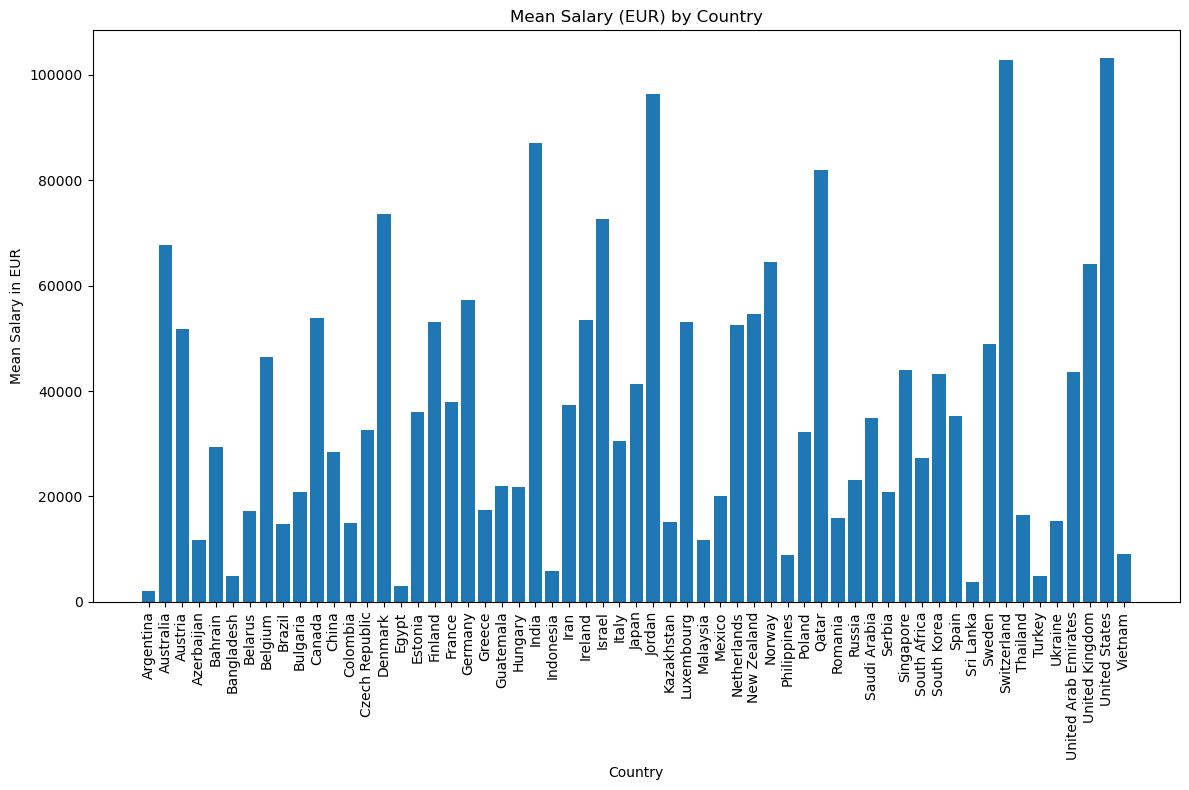

In [228]:
plt.figure(figsize=(12, 8))
plt.bar(grouped_mean_data['country'], grouped_mean_data['EUR_median'])
plt.xlabel('Country')
plt.ylabel('Mean Salary in EUR')
plt.title('Mean Salary (EUR) by Country')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Analiza zarobków według stanowiska

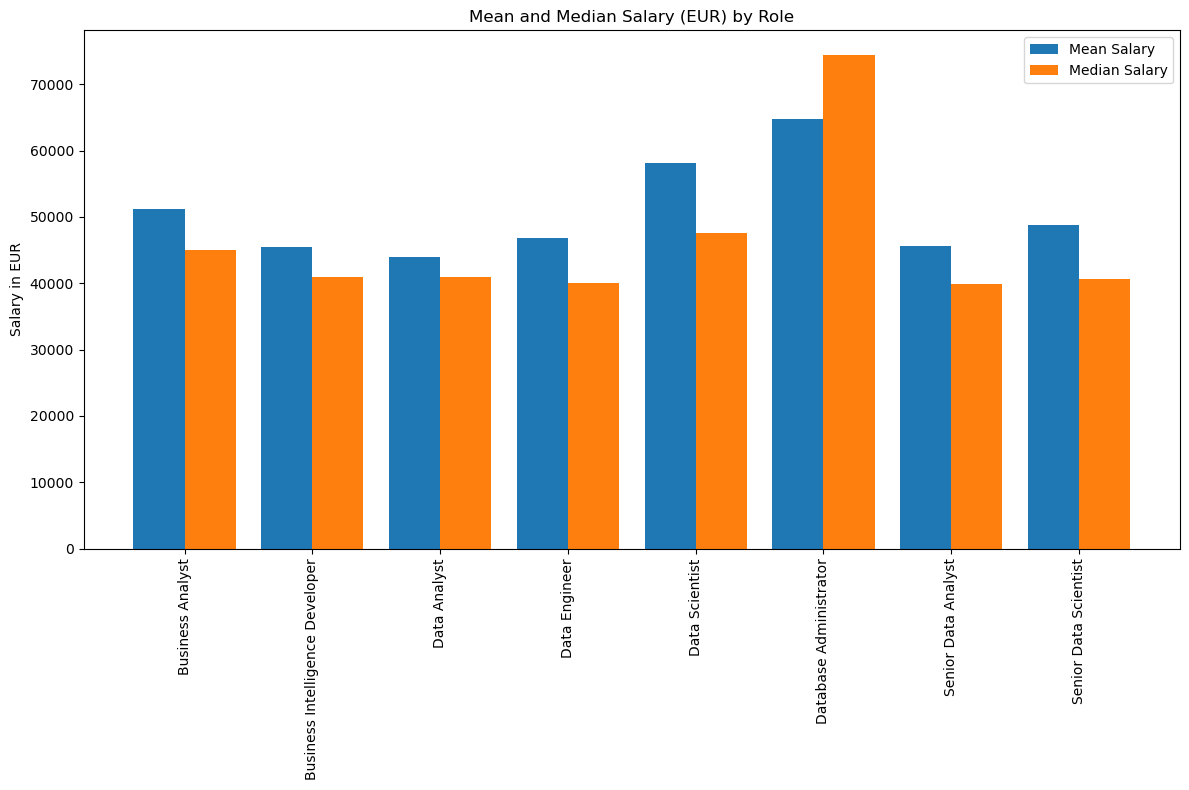

In [229]:
grouped_mean_data = a.calculate_grouped_mean('role', 'EUR_median')
grouped_median_data = a.calculate_grouped_median('role', 'EUR_median')
roles = np.array(grouped_mean_data['role'])

bar_width = 0.4
positions = np.arange(len(roles))

plt.figure(figsize=(12, 8))
plt.bar(positions - bar_width/2, grouped_mean_data['EUR_median'], width=bar_width, label='Mean Salary')
plt.bar(positions + bar_width/2, grouped_median_data['EUR_median'], width=bar_width, label='Median Salary')
plt.ylabel('Salary in EUR')
plt.title('Mean and Median Salary (EUR) by Role')
plt.xticks(positions, roles, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


### Wnioski

## Aneksy

In [230]:
clean_dataset = GlassdoorSalary(credentials['username'], credentials['key'], currencies)
clean_dataset.load_dataset()
clean_dataset.get_dataset().head(5)

,role,country,company,company_rating,job_title,median,low,high,unit
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"¥1,500,000",¥1M,¥18M,/yr
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"¥5,000,000",¥5M,¥7M,/yr
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"¥350,000",¥300K,¥402K,/mo
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"¥6,250,000",¥5M,¥8M,/yr
5,Data Scientist,Japan,Indeed,4.1,Data Scientist,"¥20,500,000",¥20M,¥21M,/yr


In [231]:
clean_dataset.process_data()
clean_dataset.get_dataset().head(5)

,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"135,275.00","130,000.00","141,000.00",/mo,ARS
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"200,004.00","193,000.00","207,000.00",/mo,ARS
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"88,726.00","85,000.00","93,000.00",/mo,ARS
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"150,000.00","100,000.00","228,000.00",/mo,ARS
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"149,630.00","144,000.00","155,000.00",/mo,ARS


In [232]:
clean_dataset.select_by_yearly_rate().head(5)

,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"1,623,300.00","1,560,000.00","1,692,000.00",/yr,ARS
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"2,400,048.00","2,316,000.00","2,484,000.00",/yr,ARS
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"1,064,712.00","1,020,000.00","1,116,000.00",/yr,ARS
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"1,800,000.00","1,200,000.00","2,736,000.00",/yr,ARS
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"1,795,560.00","1,728,000.00","1,860,000.00",/yr,ARS


In [233]:
clean_dataset.to_common_currency('EUR', exchange_provider.get_rate)

,role,country,company,company_rating,job_title,median,low,high,unit,currency,EUR_median,EUR_low,EUR_high
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"1,623,300.00","1,560,000.00","1,692,000.00",/yr,ARS,"1,675.98","1,610.63","1,746.91"
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"2,400,048.00","2,316,000.00","2,484,000.00",/yr,ARS,"2,477.94","2,391.17","2,564.62"
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"1,064,712.00","1,020,000.00","1,116,000.00",/yr,ARS,"1,099.27","1,053.10","1,152.22"
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"1,800,000.00","1,200,000.00","2,736,000.00",/yr,ARS,"1,858.42","1,238.95","2,824.80"
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"1,795,560.00","1,728,000.00","1,860,000.00",/yr,ARS,"1,853.84","1,784.08","1,920.37"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361563,Business Intelligence Developer,Vietnam,ShopeePay,3.5,Business Intelligence Analyst,"251,012,160.00","240,000,000.00","264,000,000.00",/yr,VND,"9,222.80","8,818.19","9,700.00"
361564,Business Intelligence Developer,Vietnam,GAPO Social Network Service,4.4,Business Intelligence Analyst,"11,952.00","11,472.00","12,000.00",/yr,VND,0.44,0.42,0.44
361565,Business Intelligence Developer,Vietnam,Curnon Watch,5,Business Intelligence Analyst,"96,196,800.00","96,000,000.00","96,000,000.00",/yr,VND,"3,534.51","3,527.27","3,527.27"
361566,Business Intelligence Developer,Vietnam,BeetSoft (Vietnam),4.3,Business Intelligence Analyst,"37,037,436.00","36,000,000.00","36,000,000.00",/yr,VND,"1,360.85","1,322.73","1,322.73"


In [235]:
# clean_dataset.calculate_mode('EUR_median')
# clean_dataset.calculate_grouped_mode('country', 'EUR_median')

# clean_dataset.calculate_median('EUR_median')
# clean_dataset.calculate_grouped_median('country', 'EUR_median')

# clean_dataset.calculate_std('EUR_median')
clean_dataset.calculate_grouped_std('country', 'EUR_median')

,country,EUR_median
0,Argentina,"1,679.29"
1,Australia,"28,916.86"
2,Austria,"32,248.52"
3,Azerbaijan,"6,125.41"
4,Bahrain,"22,552.17"
5,Bangladesh,"8,403.74"
6,Belarus,"7,800.80"
7,Belgium,"29,281.58"
8,Brazil,"8,451.22"
9,Bulgaria,"10,963.12"
